# detecting stars 0 - generate mock image

In [167]:
import numpy as np
import pylab as pl
import astroquery.vizier
import astropy.units as u
import pandas as pd
import astropy.wcs as pywcs
import astropy.io.fits as pyfits
import mymodule.lib

## generate the mock image

In [23]:
vizier = astroquery.vizier.Vizier()
vizier.ROW_LIMIT = -1 # unlimited number of rows returned

# https://docs.astropy.org/en/stable/coordinates/
coords = astropy.coordinates.SkyCoord(ra=('19h11m30.88s'), 
                                      dec=('+16d51m38.2s'),
                                      frame='icrs')
# https://astroquery.readthedocs.io/en/latest/
cat = vizier.query_region(coords, radius=15/60.*u.deg, catalog='I/345/gaia2')
# convert astropy Table to pandas table (much better)
cat = cat[0].to_pandas()

# catalog can be saved as an hdf file to avoid reloading an entire catalog
cat.to_hdf('data/gaia_cat.hdf5', 'data')

In [29]:
cat = pd.read_hdf('data/gaia_cat.hdf5', 'data')
cat

RA_ICRS  e_RA_ICRS    DE_ICRS  e_DE_ICRS               Source  \
0      287.945121     0.1642  16.620221     0.1892  4513275020466562944   
1      287.950043     0.2916  16.623915     0.3271  4513275020466578944   
2      287.947842     0.5374  16.620012     0.6431  4513275024780684160   
3      287.946955     0.3204  16.620399     0.3881  4513275024780685696   
4      287.955616     0.8171  16.622642     0.8230  4513275024780680192   
...           ...        ...        ...        ...                  ...   
54065  287.812860     0.1543  17.101457     0.1655  4513518463544264448   
54066  287.822447     0.2348  17.100040     0.2498  4513518459211794560   
54067  287.812171     0.2090  17.101725     0.2353  4513518463515462144   
54068  287.826095     0.4926  17.100119     0.5106  4513518463515345920   
54069  287.822485     0.1759  17.104599     0.1805  4513518459211834240   

          Plx   e_Plx   pmRA  e_pmRA    pmDE  ...    RPmag  e_RPmag   BP-RP  \
0     -0.1085  0.2173 -3.310   0.339  -6.224  ...  17.4519   0.0103  2.5408   
1     -1.8223  0.4082 -2.223   0.602  -4.306  ...  17.2831   0.0085  2.1249   
2      1.5526  0.7654 -3.043   1.153  -5.289  ...  19.0987   0.0342  1.8611   
3      0.4554  0.4386 -3.229   0.692  -7.307  ...  18.6189   0.0268  2.4656   
4     -0.8669  1.1642 -1.478   1.484  -9.348  ...  19.6692   0.0798  1.3164   
...       ...     ...    ...     ...     ...  ...      ...      ...     ...   
54065  0.5050  0.2106 -1.233   0.311 -13.357  ...  17.5202   0.0129  2.0202   
54066 -0.1087  0.2972 -1.344   0.486  -5.245  ...  18.0869   0.0137  2.2076   
54067 -0.0677  0.2762 -3.303   0.438  -6.369  ...  17.9654   0.0501  2.1753   
54068  0.2299  0.6194 -3.993   1.009  -5.555  ...  19.1263   0.1205  1.7800   
54069  0.5473  0.2306 -1.884   0.355  -7.817  ...  17.5459   0.0132  2.4811   

       RV  e_RV  Teff  AG  E_BP-RP_  Rad  Lum  
0     NaN   NaN   NaN NaN       NaN  NaN  NaN  
1     NaN   NaN   NaN NaN       NaN  NaN  NaN  
2     NaN   NaN   NaN NaN       NaN  NaN  NaN  
3     NaN   NaN   NaN NaN       NaN  NaN  NaN  
4     NaN   NaN   NaN NaN       NaN  NaN  NaN  
...    ..   ...   ...  ..       ...  ...  ...  
54065 NaN   NaN   NaN NaN       NaN  NaN  NaN  
54066 NaN   NaN   NaN NaN       NaN  NaN  NaN  
54067 NaN   NaN   NaN NaN       NaN  NaN  NaN  
54068 NaN   NaN   NaN NaN       NaN  NaN  NaN  
54069 NaN   NaN   NaN NaN       NaN  NaN  NaN  

[54070 rows x 32 columns]

In [30]:
cat.keys()

Index(['RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx',
       'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', 'FG', 'e_FG',
       'Gmag', 'e_Gmag', 'FBP', 'e_FBP', 'BPmag', 'e_BPmag', 'FRP', 'e_FRP',
       'RPmag', 'e_RPmag', 'BP-RP', 'RV', 'e_RV', 'Teff', 'AG', 'E_BP-RP_',
       'Rad', 'Lum'],
      dtype='object')

In [86]:
cat = cat.sort_values(by='Gmag') # array is sorted by magnitude in G-band

In [89]:
cat['Gmag']
print(cat['Gmag'].values[0])

7.7362


### CCD image simulation

#### mock WCS 
let's create a mock WCS for a 2048x2064 image with a FOV of 11 arcminutes and centered on the same region as the catalog

see https://docs.astropy.org/en/stable/wcs/

In [53]:
coords.ra.to(u.deg).value, coords.dec.to(u.deg).value

(287.8786666666666, 16.860611111111112)

In [66]:
DIMX = 2048
DIMY = 2064
FOV = 11 # arcminutes along X
scale = FOV / 60. / DIMX # arcdeg / pixel

w = pywcs.WCS(naxis=2)
w.wcs.crpix = [DIMX / 2., DIMY / 2.]
w.wcs.cdelt = [-scale, scale] # must be in arcdeg/pixel
w.wcs.crval = [coords.ra.to(u.deg).value, coords.dec.to(u.deg).value]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
w.wcs.radesys = 'ICRS'
w.wcs.equinox = 2000.

# check the wcs, it should give DIMX/2 - 1, DIMY/2 - 1
w.all_world2pix([[coords.ra.to(u.deg).value, coords.dec.to(u.deg).value]], 0)

array([[1023., 1031.]])

#### mock stars

Mock stars PSF will follow a Moffat model

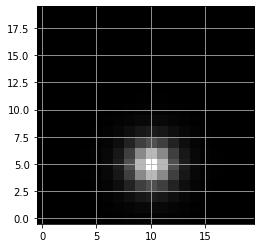

In [169]:
pl.imshow(mymodule.lib.star(20, 1000, 10, 5), cmap='gray', origin='bottom-left')
pl.grid()

In [100]:
# compute the positions of the stars in the image
allxy = w.all_world2pix(np.array([cat['RA_ICRS'].values, cat['DE_ICRS'].values]).T, 0)
cat['x'] = allxy[:,0]
cat['y'] = allxy[:,1]

In [109]:
# convert Gmag to a flux in erg/cm2/s/AA
LIGHT_VEL_AAS = 2.99792458e18
G_BAND_NM = 600
ABmag2fnu = lambda ABmag: 10**(-0.4*(ABmag + 48.60)) # convert ABmag to a flux in erg/cm2/s/Hz
lambda2nu = lambda lam: LIGHT_VEL_AAS / lam # convert a frequency in Hz to a wavelength in AA
fnu2flambda = lambda fnu, nu: fnu * nu**2. / LIGHT_VEL_AAS # convert a flux in erg/cm2/s/Hz in erg/cm2/s/AA
ABmag2flambda = lambda ABmag, lam: fnu2flambda(ABmag2fnu(ABmag), lambda2nu(lam)) # convert ABmag to a flux in erg/cm2/s/AA
cat['flambda'] = ABmag2flambda(cat['Gmag'].values, G_BAND_NM * 10)

In [110]:
cat['flambda']

29049    2.432418e-12
39313    6.617260e-13
23452    4.255183e-13
36986    3.923902e-13
18344    2.896798e-13
             ...     
15263    7.768161e-18
11878    7.736031e-18
15617    7.662283e-18
35554    7.606033e-18
12448    7.482353e-18
Name: flambda, Length: 54070, dtype: float64

In [121]:
# convert a flux in erg/cm2/s/AA to a number of counts
# energy of one photon
PLANCK = 6.6260755e-27 # planck constant in erg.s
LIGHT_VEL_KMS = 299792.458 # c in km/s
MIRROR_AREA = 81700 # CFHT telescope surface in cm2
EXPOSITION_TIME = 30 # exposition time in s
photon_energy = PLANCK * LIGHT_VEL_KMS * 1e12 / G_BAND_NM # photon energy in erg
cat['real_counts'] = (cat['flambda'].values / photon_energy * MIRROR_AREA * EXPOSITION_TIME).astype(int)


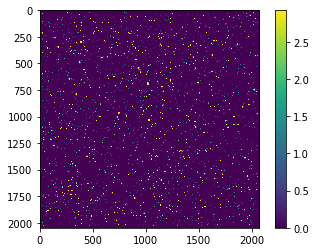

In [164]:
# to accelerate the process, stars are computed in 20x20 boxes and added to the mock image one by one
N_STARS = 20000
BOX_SIZE = 20
im = np.zeros((2048, 2064), dtype=float)
for i in range(N_STARS):
    ix = cat['x'].values[i]
    iy = cat['y'].values[i]
    
    if ix < BOX_SIZE: continue
    if ix > im.shape[1] - BOX_SIZE: continue
    if iy < BOX_SIZE: continue
    if iy > im.shape[0] - BOX_SIZE: continue
    
    
    x_min = int(ix - BOX_SIZE / 2)
    y_min = int(iy - BOX_SIZE / 2)
    iflux = cat['real_counts'].values[i]
    im[y_min:y_min+BOX_SIZE, x_min:x_min+BOX_SIZE] += mymodule.lib.star(
        BOX_SIZE, iflux, ix - x_min, iy - y_min)
    
pl.figure()
pl.imshow(im, vmin=np.nanpercentile(im, 5),  vmax=np.nanpercentile(im, 99))
pl.colorbar()

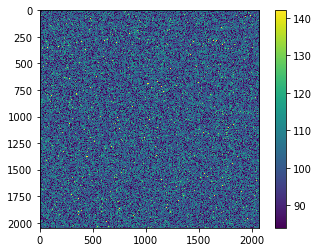

In [165]:
# now we finish the simulation by adding a background and simulating the photon noise
BACKGROUND = 100
im += BACKGROUND

im = im.astype(int)

im = np.random.poisson(im)

pl.figure()
pl.imshow(im, vmin=np.nanpercentile(im, 5),  vmax=np.nanpercentile(im, 99.9))
pl.colorbar()

pyfits.writeto('data/mock_star_field.fits', im, header=w.to_header(), overwrite=True)